In [22]:
import os

# Define the directory path
directory = r'F:\GitHub\KU-1\Variations\New Data\Measurements'

# Create an empty list to store the file paths
file_paths = []

# Loop through all the files in the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a .csv file
        if file.endswith('.csv'):
            # If it is, append its path (relative to the directory) to the csv_files list
            file_paths.append(os.path.join(root[len(directory)+1:], file))

# Add the directory path to each file path in the list
file_paths = [os.path.join('New Data', 'Measurements', file).replace('\\', '/') for file in file_paths]

# Print the list of .csv file paths
print(file_paths)


['New Data/Measurements/aftersound_L.csv', 'New Data/Measurements/aftersound_R.csv', 'New Data/Measurements/banbeu_L.csv', 'New Data/Measurements/banbeu_R.csv', 'New Data/Measurements/bryaudioreview_L.csv', 'New Data/Measurements/bryaudioreview_R.csv', 'New Data/Measurements/cammyfi_S1_L.csv', 'New Data/Measurements/cammyfi_S1_R.csv', 'New Data/Measurements/crinacle_L.csv', 'New Data/Measurements/crinacle_R.csv', 'New Data/Measurements/discord_cammy_L.csv', 'New Data/Measurements/discord_cammy_sharur.csv', 'New Data/Measurements/discord_yanim.csv', 'New Data/Measurements/gizaudio_L.csv', 'New Data/Measurements/gizaudio_R.csv', 'New Data/Measurements/harpo_R.csv', 'New Data/Measurements/hobbytalk_L.csv', 'New Data/Measurements/hobbytalk_R.csv', 'New Data/Measurements/moondrop.csv', 'New Data/Measurements/neptoneaudio_L.csv', 'New Data/Measurements/neptoneaudio_R.csv', 'New Data/Measurements/nymz_L.csv', 'New Data/Measurements/nymz_R.csv', 'New Data/Measurements/precog_S1_L.csv', 'New Da

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# List of file paths
# file_paths = [
#     'Measurements/vari_super_s1.csv',
#     'Measurements/vari_super_s2.csv',
#     'Measurements/vari_precog_s1.csv',
#     'Measurements/vari_precog_s2.csv',
#     'Measurements/vari_precog_s3.csv',
#     'Measurements/vari_nymz.csv',
#     'Measurements/vari_hobbytalk_stock.csv',
#     'Measurements/vari_hbb.csv',
#     'Measurements/vari_harpo.csv',
#     'Measurements/vari_gizaudio.csv',
#     'Measurements/vari_crinacle.csv',
#     'Measurements/vari_aftersound.csv',
#     'Measurements/CammyFi.csv',
#     'Measurements/BryAudioReviews.csv',
#     'Measurements/Vari_105dBC.csv',
#     'Measurements/Vari_85dBC.csv',
#     'Measurements/Vari_77dBC.csv',
#     'Measurements/Moondrop_Measurement_Official.csv',
# ]

# Function to read and interpolate a .csv file
def read_and_interpolate(file_path, x_values):
    df = pd.read_csv(file_path)
    min_x = df['X'].min()
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values

# X values to interpolate to (logarithmically spaced from 20 Hz to 20 kHz)
x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

# Read and interpolate all .csv files
data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

def find_optimal_shift(ref_data, data, x_min, x_max):
    indices = (x_values >= x_min) & (x_values <= x_max)
    ref_data = ref_data[indices]
    data = data[indices]

    shift_values = np.linspace(-10, 10, 500)
    min_mse = float('inf')
    optimal_shift = 0

    for shift in shift_values:
        mse = np.mean((ref_data - (data + shift))**2)
        if mse < min_mse:
            min_mse = mse
            optimal_shift = shift

    return optimal_shift

# Calculate initial average of all datasets (without alignment)
initial_average = np.mean(data, axis=0)

# Align all datasets using mean squared error minimization
alignment_freq_range = (200, 10000)  # frequency range for alignment

for i in range(len(data)):
    shift = find_optimal_shift(initial_average, data[i], *alignment_freq_range)
    data[i] += shift

# Compute the final average of the aligned datasets
average = np.mean(data, axis=0)

# Align the final average plot to the initial average plot
average_shift = find_optimal_shift(initial_average, average, *alignment_freq_range)
average += average_shift

# Save the average to a .csv file
average_df = pd.DataFrame({'X': x_values, 'Y': average})
average_df.to_csv('Measurements/average_newnew.csv', index=False)


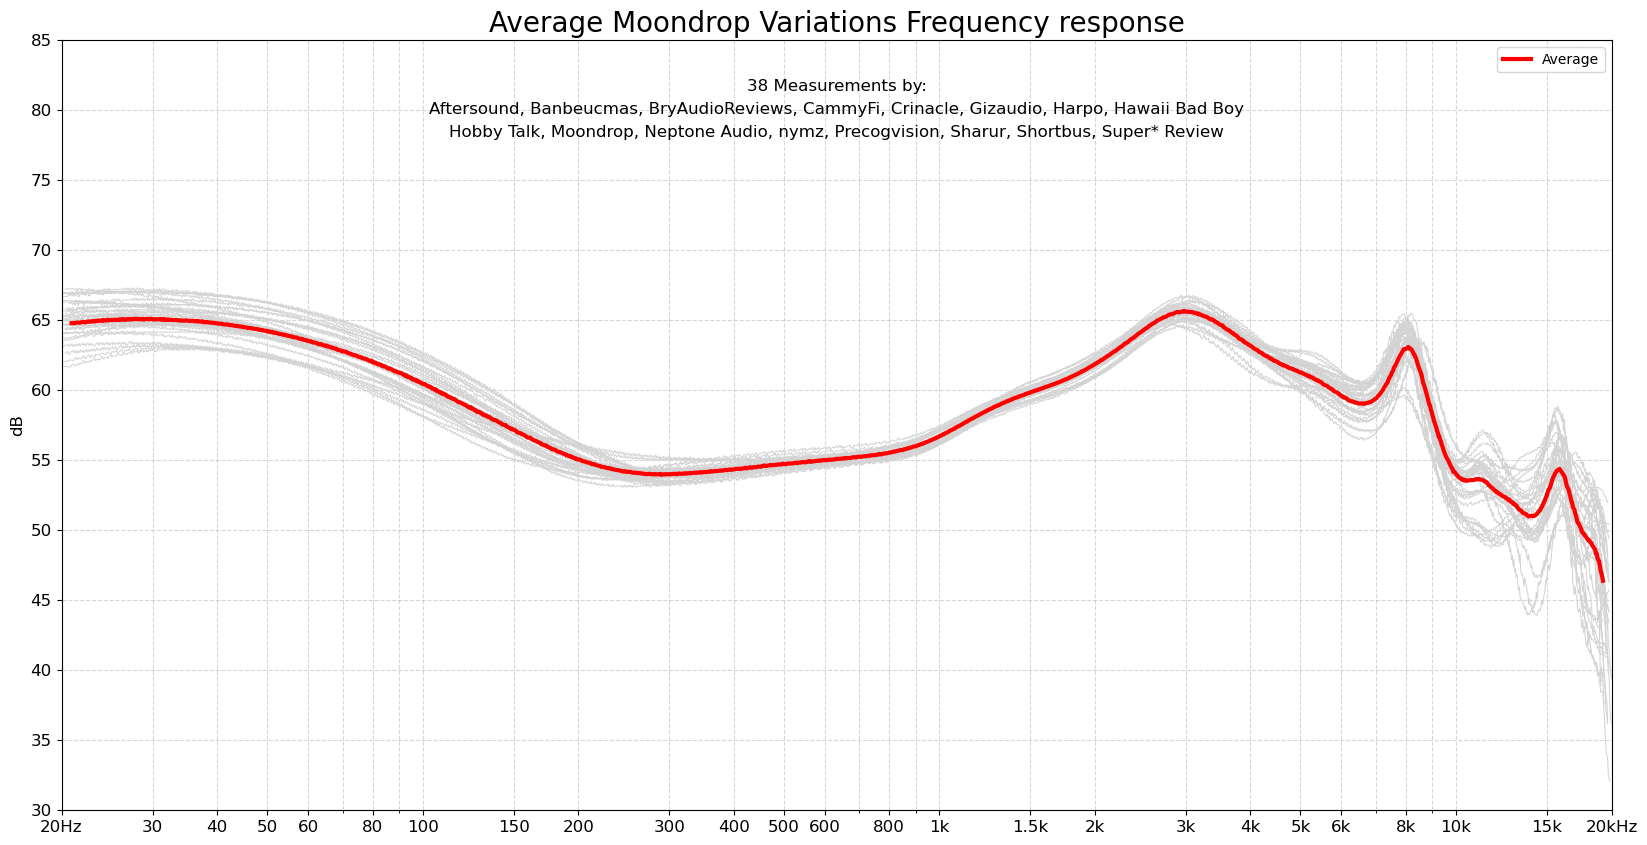

In [24]:
# Plot all datasets in gray and the average in red
plt.figure(figsize=(20, 10))
for y_values in data:
    plt.plot(x_values, y_values, color='lightgray', linewidth=0.75)
plt.ylim(30, 85)
plt.xlim(20, 20000)
plt.plot(x_values, average, color='red', linewidth=3, label='Average')
plt.xscale('log')

# Customize Y-axis
plt.yticks(np.arange(30, 86, 5), fontsize=12)

# Customize X-axis
x_ticks = np.array([
    20, 30, 40, 50, 60, 80, 100, 150,
    200, 300, 400, 500, 600, 800,
    1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
    10000, 15000, 20000
])
labels = [
    f'{int(x)}Hz' if x == 20
    else f'{int(x)}' if x < 1000
    else f'{x/1000:.1f}k' if x == 1500
    else f'{x//1000:.0f}k' if x != 20000
    else '20kHz' for x in x_ticks
]
plt.xticks(x_ticks, labels=labels, fontsize=12)

# Set labels and title
plt.ylabel('dB', fontsize=12)
plt.title('Average Moondrop Variations Frequency response', fontsize=20)

# Subtitle
plt.text(0.5, 0.95, '38 Measurements by:', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
plt.text(0.5, 0.92, 'Aftersound, Banbeucmas, BryAudioReviews, CammyFi, Crinacle, Gizaudio, Harpo, Hawaii Bad Boy', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')
plt.text(0.5, 0.89, 'Hobby Talk, Moondrop, Neptone Audio, nymz, Precogvision, Sharur, Shortbus, Super* Review', fontsize=12, transform=plt.gca().transAxes, horizontalalignment='center', verticalalignment='top')

# Legend
plt.legend()

# Customize grid
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()
